In [533]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
import pandas as pd
import seaborn as snb
import copy

In [540]:
import astropy.io.fits as fits
from astropy.table import Table

import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformer import TransformerReg, TransAm
# from train_ap14 import ASPCAP
from data import AP_cat, AP_norm
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [543]:
data_dir = "/data/jdli/sdss/"
tr_file = "hogg19_spec_nnnorm_tr.npy"
cat = "apRG14_tr.fits"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 4

apdata  = AP_cat(data_dir+tr_file, cat_name=data_dir+cat, total_num=TOTAL_NUM,
part_train=False, device=device)

A_size = int(0.5*len(apdata))
B_size = len(apdata) - A_size
A_dataset, B_dataset = torch.utils.data.random_split(apdata, [A_size, B_size], generator=torch.Generator().manual_seed(42))
print(len(A_dataset), len(B_dataset))

A_loader = DataLoader(A_dataset, batch_size=BATCH_SIZE, )
B_loader = DataLoader(B_dataset, batch_size=BATCH_SIZE, )


# ## Model parameters
# dim_val = 64 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
# n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
# n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
# n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
# input_size = 1 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 7514+5 # length of input given to encoder. Can have any integer value.
# dec_seq_len = 2 # length of input given to decoder. Can have any integer value.
# output_sequence_length = 2 # Length of the target sequence, i.e. how many time steps should your forecast
# max_seq_len = 7514+5 # What's the longest sequence the model will encounter? Used to make the positional encoder
# model_A = TransformerReg(dim_val=dim_val, input_size=input_size, 
#                        batch_first=True, dec_seq_len=dec_seq_len, 
#                        out_seq_len=output_sequence_length, n_decoder_layers=n_decoder_layers,
#                        n_encoder_layers=n_encoder_layers, n_heads=n_heads,
#                        max_seq_len=max_seq_len,
#                        ).to(device)
# model_B = copy.deepcopy(model_A)

model_A = TransAm(
    feature_size=64, enc_len=enc_seq_len, tgt_len=2, num_layers=2, dropout=0.2
).to(device)

10533 10534


In [550]:
!ls -al /data/jdli/sdss/model/

total 89084
drwxrwxr-x. 2 jdli jdli    4096 Nov  7 17:24 .
drwxrwxr-x. 6 jdli jdli    4096 Nov  1 23:34 ..
-rw-rw-r--. 1 jdli jdli 6852444 Oct 19 23:50 ap_prlx_trsfm_221018.pt
-rw-rw-r--. 1 jdli jdli 1681436 Oct 20 09:49 ap_prlx_trsfm_221019.pt
-rw-rw-r--. 1 jdli jdli 6852444 Oct 20 20:56 ap_prlx_trsfm_error221020.pt
-rw-rw-r--. 1 jdli jdli 6852444 Oct 21 16:47 ap_prlx_trsfm_error221021A.pt
-rw-rw-r--. 1 jdli jdli 6852444 Oct 22 04:19 ap_prlx_trsfm_error221021B.pt
-rw-rw-r--. 1 jdli jdli 6582108 Oct 25 15:09 ap_prlx_trsfm_error221023A_nnNorm.pt
-rw-rw-r--. 1 jdli jdli 6582108 Oct 25 09:38 ap_prlx_trsfm_error221023B_nnNorm.pt
-rw-rw-r--. 1 jdli jdli 6582108 Oct 28 08:31 trsfm_221025A.pt
-rw-rw-r--. 1 jdli jdli 6582108 Oct 27 08:23 trsfm_221025B.pt
-rw-rw-r--. 1 jdli jdli 6580828 Oct 29 05:49 trsfm_221028_fakeA.pt
-rw-rw-r--. 1 jdli jdli 6582108 Oct 30 20:33 trsfm_221029A.pt
-rw-rw-r--. 1 jdli jdli 6582108 Nov  1 11:01 trsfm_221031Aep10.pt
-rw-rw-r--. 1 jdli jdli 6582108 Nov  2 08:22 trs

In [554]:
model_name_A = "model/trsfm_221106Aep30.pt"
model_name_B = "model/trsfm_221025B.pt"

model_A.load_state_dict(torch.load(data_dir+model_name_A))
model_B.load_state_dict(torch.load(data_dir+model_name_B))

<All keys matched successfully>

In [545]:
def predict(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            # output = model(data['x'], data['y'])
            output = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_lst = np.append(id_lst, data['id'])
            del output, data

    out_lst, y_lst = np.array(out_lst).reshape(-1,2), np.array(y_lst).reshape(-1,2)
    return out_lst, y_lst, id_lst


In [552]:
out_lst_B, y_lst_B, id_lst_B = predict(B_loader, model_A)



100%|████████████████████████████████████████████████████████████████████| 2634/2634 [00:27<00:00, 95.78it/s]


In [444]:
        
# out_lst_A, y_lst_A, id_lst_A = predict(A_loader, model_B)


100%|████████████████████████████████████████████████████████████████████| 2634/2634 [04:29<00:00,  9.77it/s]


In [ ]:
# from timebudget import timebudget
# import ray
# from tqdm import tqdm

# # ray.init()

# # @ray.remote
# def pred_batch(batch):
#     x, y = batch
    
#     with torch.no_grad():
#         output = model(x, y) 
#     # del x, y, output
#     return output.numpy(), y.numpy()

# @timebudget
# def ray_dataloader(func, dataloader):
#     data = ray.get([func.remote(batch) for batch in dataloader])
#     return data


# data = ray_dataloader(pred_batch, B_loader)

# from multiprocessing import Pool
# import os

# print('Number of CPUs in the system: {}'.format(os.cpu_count()))

# def pred_batch(batch):
#     x, y = batch
    
#     with torch.no_grad():
#         output = model(x, y) 
#     # del x, y, output
#     return (output.numpy(), y.numpy())


# @timebudget
# def run_complex_operations(operation, inpt, pool):
#     y = pool.map(operation, inpt)
#     return y



In [445]:
def draw_compare(out_lst, y_lst, errorbar=True):
    xx = np.linspace(-0.5, 1.5)
    
    norm_res = y_lst[:,0]-out_lst[:,0]
    print("residuals mean : %.2f, scatter : %.2f "%(np.nanmedian(norm_res), np.nanstd(norm_res)))
    print("residuals/y mean : %.2f percent"%(100./np.nanmedian(y_lst[:,0]/norm_res)))

    varpi_bin = np.linspace(-0.3, 1.3, 10)
    e_varpi = []

    for i in range(len(varpi_bin)-1):
        ind = (y_lst[:,0]>varpi_bin[i]) & (y_lst[:,0]<=varpi_bin[i+1])

        e_varpi.append(np.median(y_lst[:,1][ind]))
    
    fig, ax = plt.subplots(1,1, figsize=(6,6),  sharex=True)
    ax.plot(xx, xx, ls=':', lw=3, c='k', zorder=5)
    
    if errorbar:
        ax.errorbar(y_lst[:,0], out_lst[:,0],
                      xerr=y_lst[:,1], yerr=np.abs(out_lst[:,1]),
                     capthick=0.01, fmt='.', capsize=0, c='royalblue', alpha=0.1, zorder=4)
    else:
        ax.scatter(y_lst[:,0], out_lst[:,0], s=1,
                   marker='.', c='royalblue', alpha=0.5, zorder=4)

    ax.set_xlim([-0.3, 1.2]);
    ax.set_ylim([-0.3, 1.2]);
    ax.set_ylabel(r"Trans. $\varpi$ (mas)");
    ax.annotate("scatter = %.4f mas"%(np.nanstd(norm_res)), 
                (0.58, 0.35), xycoords="figure fraction",zorder=3)
    ax.annotate("  bias   = %.4f mas"%(np.nanmean(norm_res)), 
                (0.58, 0.40), xycoords="figure fraction",zorder=3)
    
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="33%", pad=0)

    norm_res = y_lst[:,0]-out_lst[:,0]
    ax.figure.add_axes(ax2)
    ax2.scatter(y_lst[:,0], norm_res, color="crimson", s=1, zorder=5)
    ax2.axhline(y=0, c='k', zorder=4, lw=3, ls=":")
    ax2.set_xlabel(r"Gaia $\varpi$ (mas)");
    ax2.set_ylim([-0.42, 0.42]);
    ax2.set_xlim([-0.3, 1.2]);
    ax2.set_ylabel(r'$\Delta \varpi$ (mas)');

    for i in range(len(varpi_bin)-1):
        ax2.axhspan(-e_varpi[i], e_varpi[i], varpi_bin[i], varpi_bin[i+1],
                    facecolor='grey', alpha=0.6, zorder=6)
    ax.set_xticks([]);

    return fig, ax

residuals mean : 0.00, scatter : 0.01 
residuals/y mean : 2.84 percent


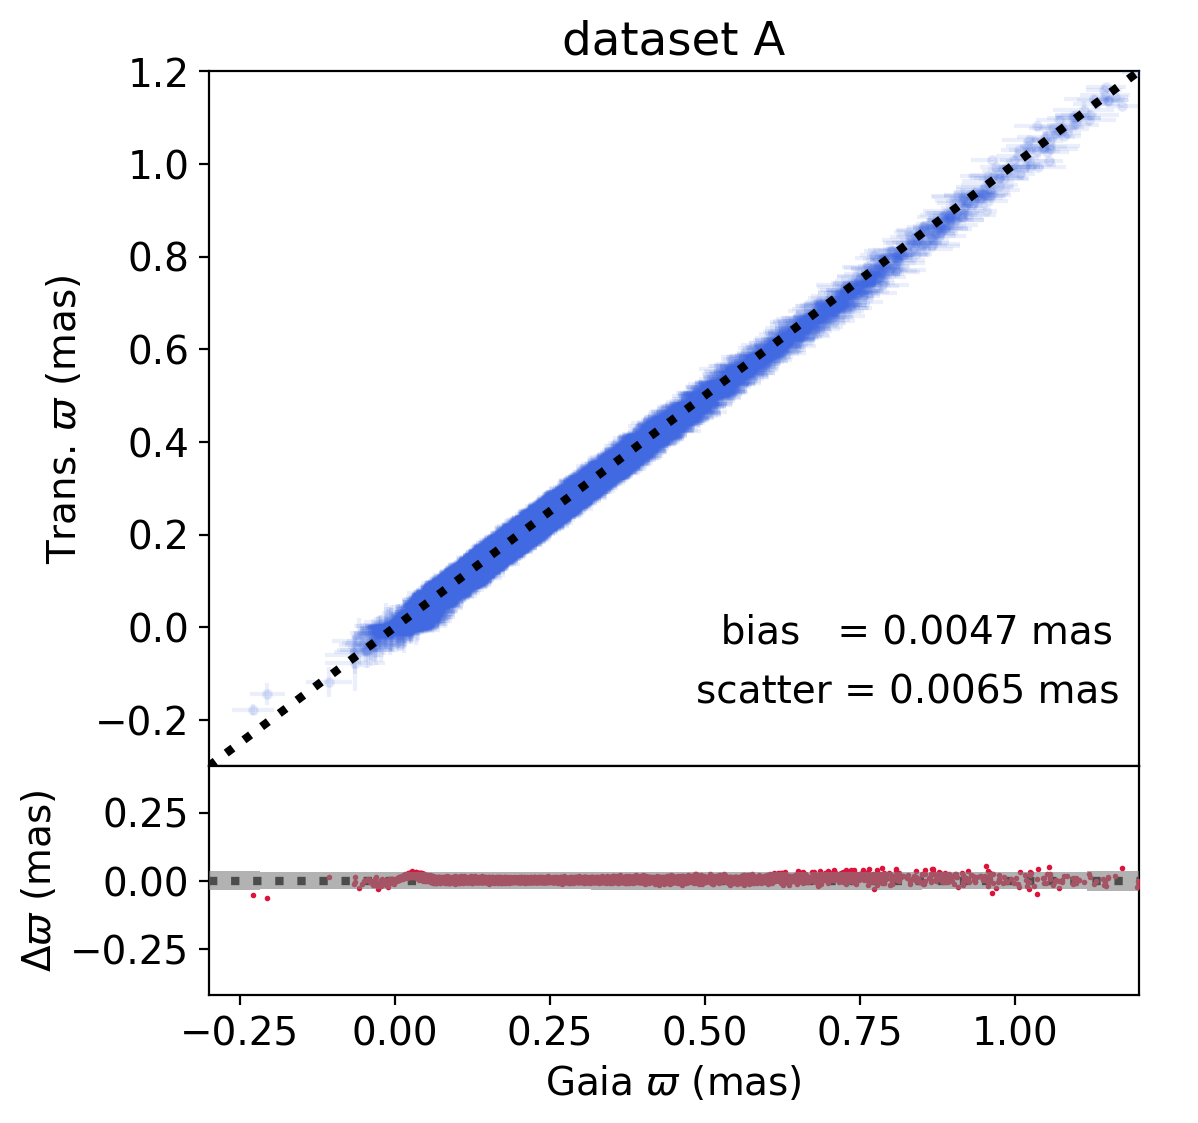

In [513]:

fig, ax = draw_compare(out_lst_A, y_lst_A)
ax.set_title("dataset A");


residuals mean : -0.00, scatter : 0.19 
residuals/y mean : -1493.15 percent


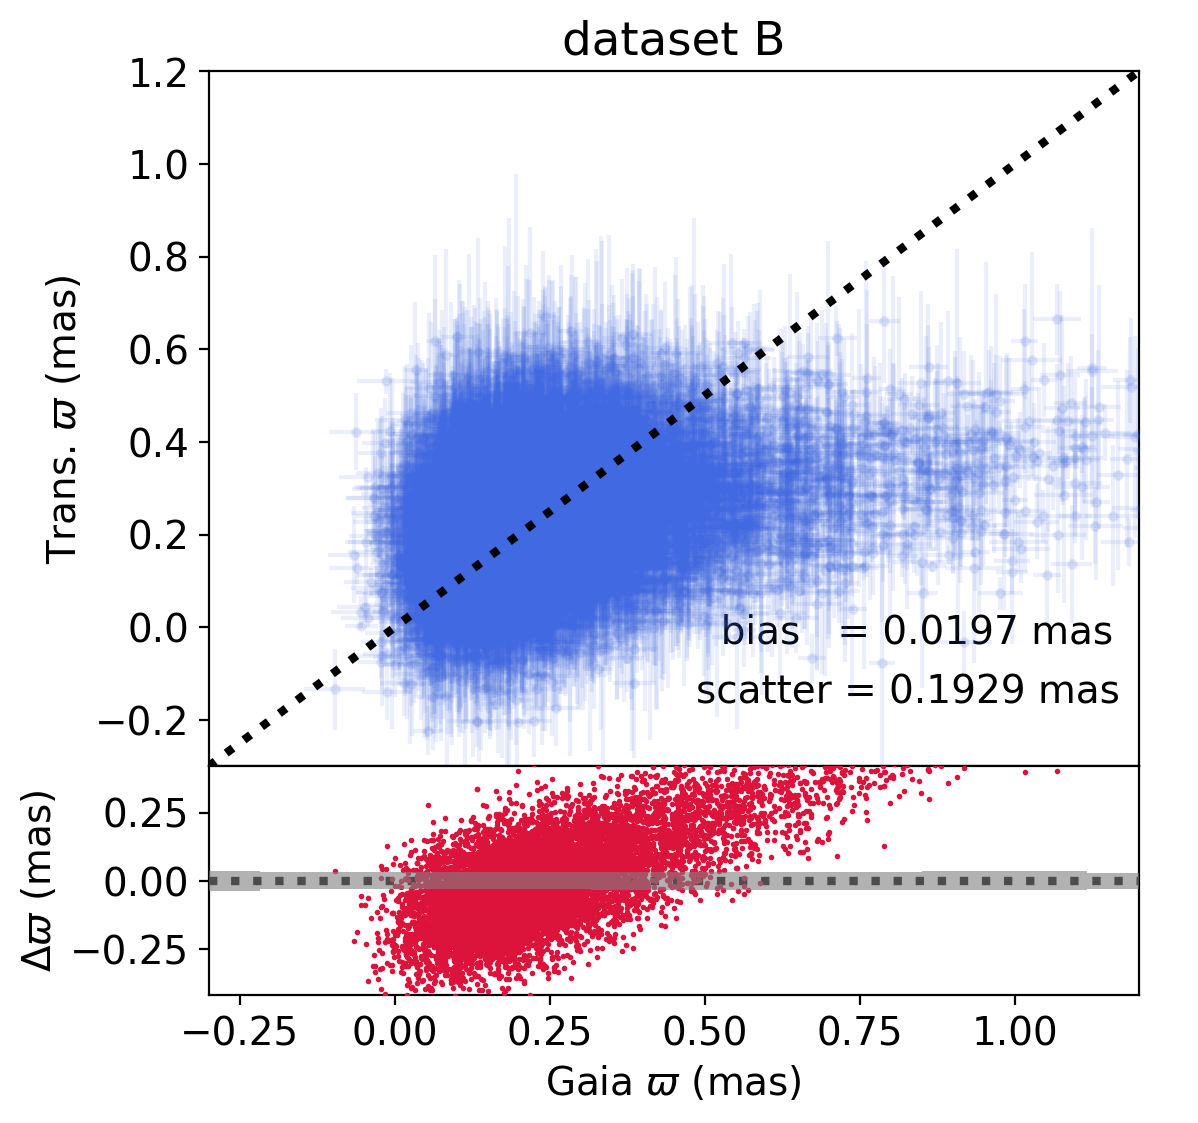

In [553]:
fig, ax = draw_compare(out_lst_B, y_lst_B)
ax.set_title("dataset B");

In [230]:
outcome_df = pd.DataFrame({
    'trans_prlx':np.append(out_lst_A[:,0], out_lst_B[:,0]),
    'e_trans_prlx':np.abs(np.append(out_lst_A[:,1], out_lst_B[:,1])),
    'tmass_id':np.append(id_lst_A, id_lst_B)
})


t = Table.from_pandas(outcome_df)
t.write(data_dir+'trans_1025.fits', overwrite=True)
t.write('trans_1025.fits', overwrite=True)

# Parent catalog

In [515]:
par_file = "hogg19_spec_nnnorm_val.npy"

BATCH_SIZE = 4

ap_parent  = AP_norm(data_dir+par_file, part_train=False, device=device)
parent_loader = DataLoader(ap_parent, batch_size=BATCH_SIZE, )

print(len(ap_parent))
ap_parent[0]

16557


{'x': tensor([[-0.4435],
         [-0.2730],
         [-0.1033],
         ...,
         [ 7.3140],
         [ 7.2570],
         [ 7.3530]], device='cuda:0'),
 'y': tensor([[0.3191],
         [0.0329]], device='cuda:0'),
 'id': '2M00000002+7417074'}

In [520]:
!ls -al /data/jdli/sdss/

total 12465296
drwxrwxr-x.  6 jdli jdli       4096 Nov  1 02:07 .
drwxrwxrwx. 25 root root       4096 Oct 30 10:02 ..
-rw-rw-r--.  1 jdli jdli    8792640 Oct 26 04:47 apRG14_tr.fits
-rw-rw-r--.  1 jdli jdli   97260480 Oct 18 11:27 data_Hogg18.fits
-rw-rw-r--.  1 jdli jdli   12159360 Oct 25 02:29 data_Hogg18_wise.fits
-rw-rw-r--.  1 jdli jdli   17130240 Oct 25 06:14 data_Hogg18_wise_gdr3.fits
-rw-rw-r--.  1 jdli jdli    2649600 Oct 18 11:26 data_HoggEilersRix2018.fits
drwxrwxr-x.  4 jdli jdli       4096 Oct 19 00:14 dr14
drwxrwxr-x.  3 jdli jdli       4096 Oct 12 04:00 dr16
drwxrwxr-x.  3 jdli jdli       4096 Oct 27 04:25 dr17
-rw-rw-r--.  1 jdli jdli 2714347932 Oct 23 23:25 hogg19_spec_nnnorm.npy
-rw-rw-r--.  1 jdli jdli 1709994053 Nov  1 11:52 hogg19_spec_nnnorm_tr.npy
-rw-rw-r--.  1 jdli jdli 1003486573 Nov  1 11:52 hogg19_spec_nnnorm_val.npy
-rw-rw-r--.  1 jdli jdli 1027866624 Oct 19 11:25 hogg19_spec.npy
-rw-r--r--.  1 jdli jdli 3882645489 Oct 19 11:32 hogg19_spec_tr.npy
-rw-r--r--

In [446]:
out_prt_A, y_prt_A, id_prt_A = predict(parent_loader, model_A)


100%|████████████████████████████████████████████████████████████████████| 4140/4140 [07:02<00:00,  9.79it/s]


In [ ]:
out_prt_B, y_prt_B, id_prt_B = predict(parent_loader, model_B)


 34%|███████████████████████▎                                            | 1419/4140 [02:56<05:27,  8.32it/s]

residuals mean : 0.00, scatter : 0.10 
residuals/y mean : 9.51 percent


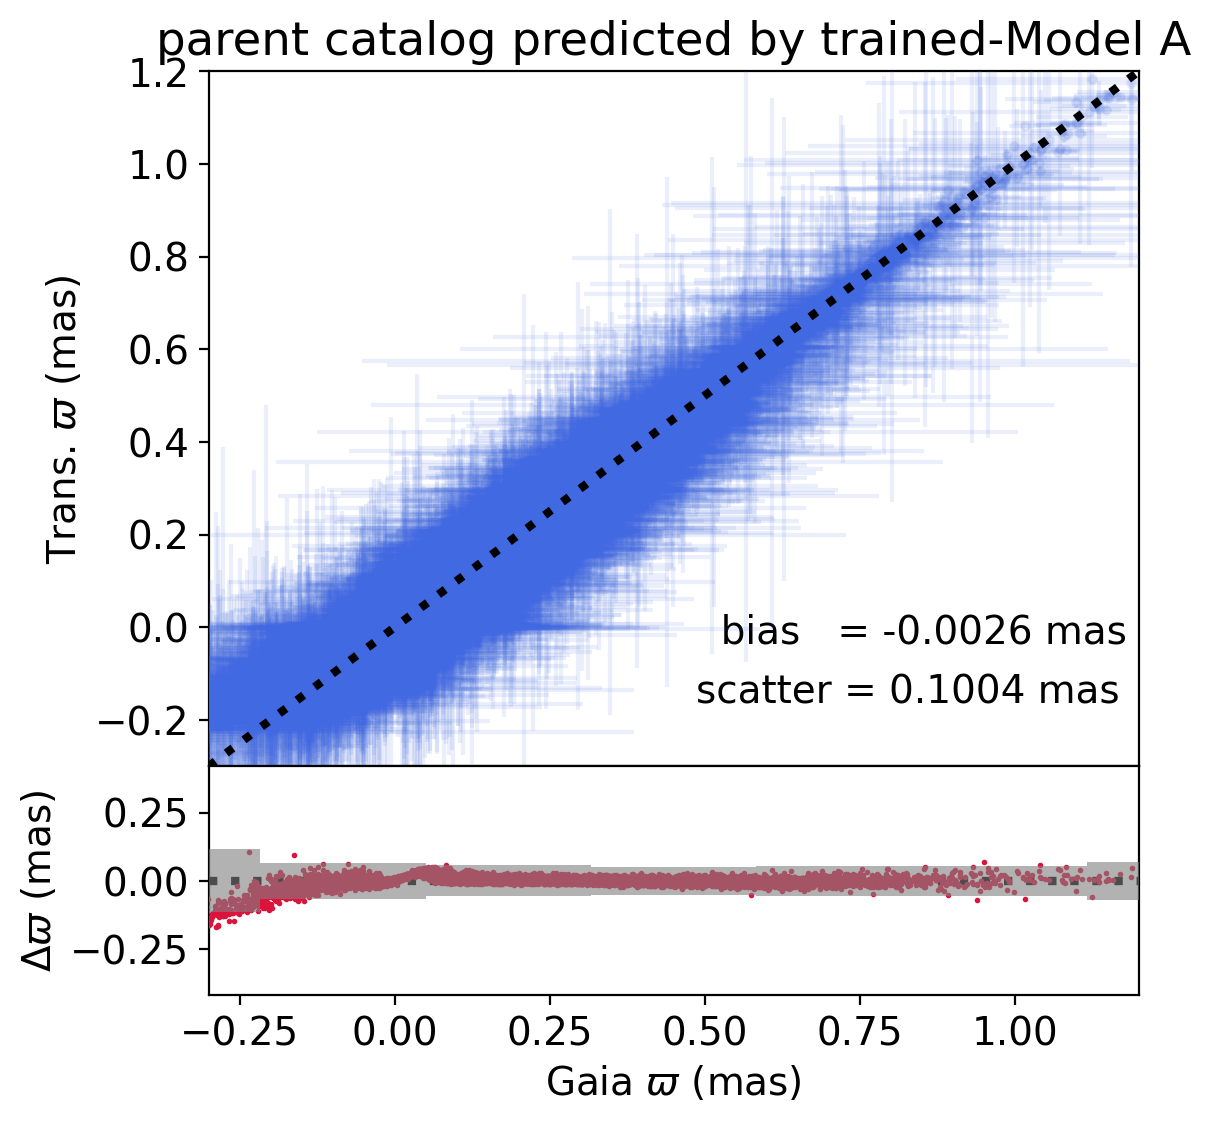

In [507]:
ind = (out_prt[:,0]>-0.5)

fig, ax = draw_compare(out_prt_A, y_prt_A)
ax.set_title("parent catalog predicted by trained-Model A");
ax.set_ylabel(r"Trans. $\varpi$ (mas)");


residuals mean : -0.00, scatter : 0.10 
residuals/y mean : -10.51 percent


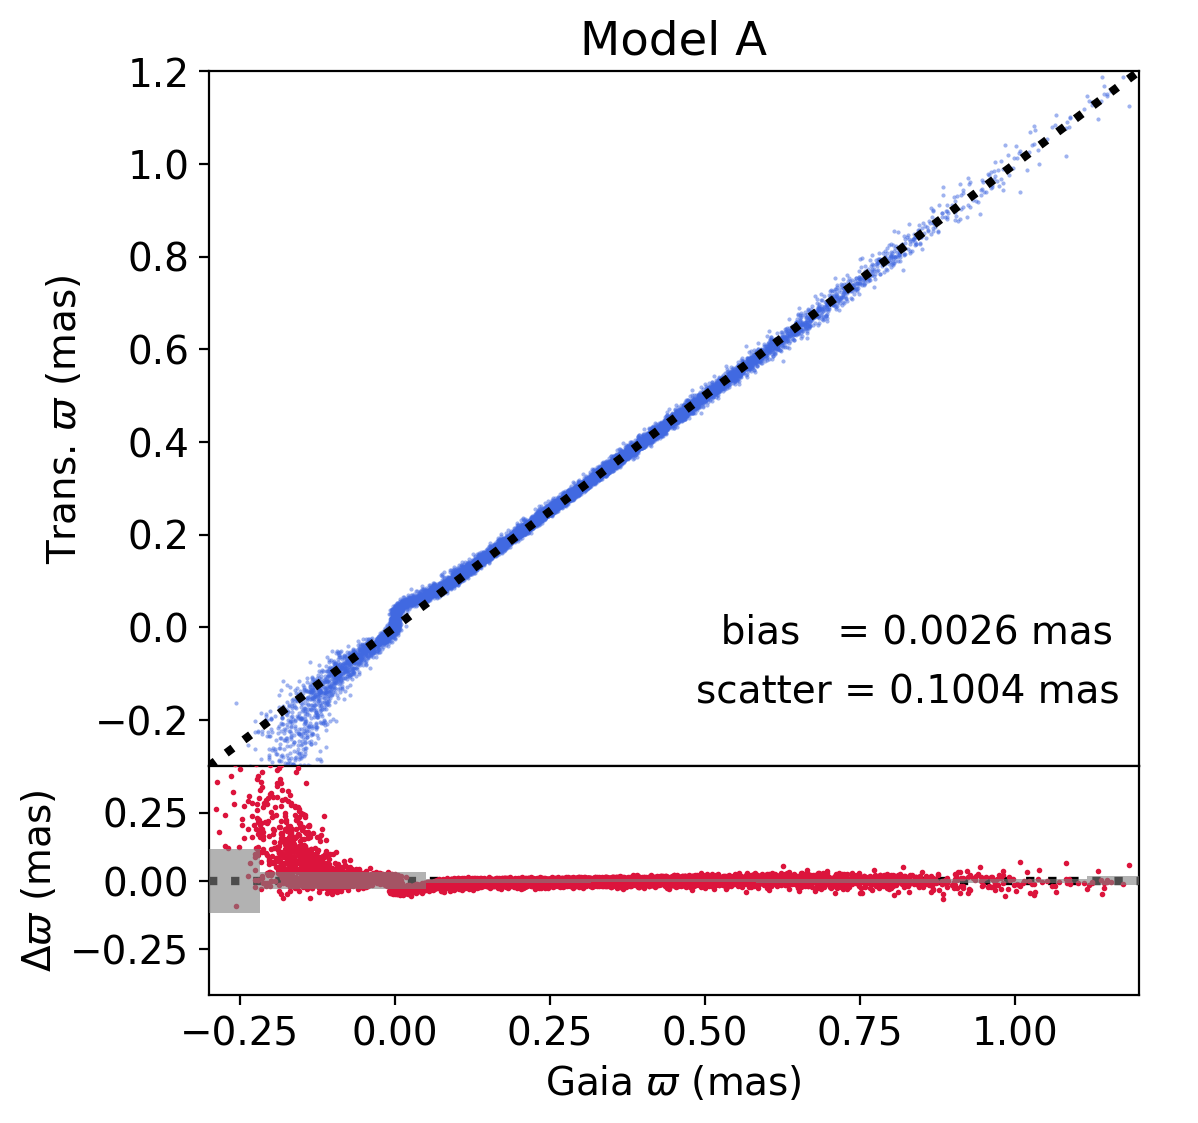

In [450]:

fig, ax = draw_compare(y_prt_A, out_prt_A, errorbar=False)
ax.set_title("Model A");

residuals mean : -0.01, scatter : 0.10 
residuals/y mean : -4.05 percent


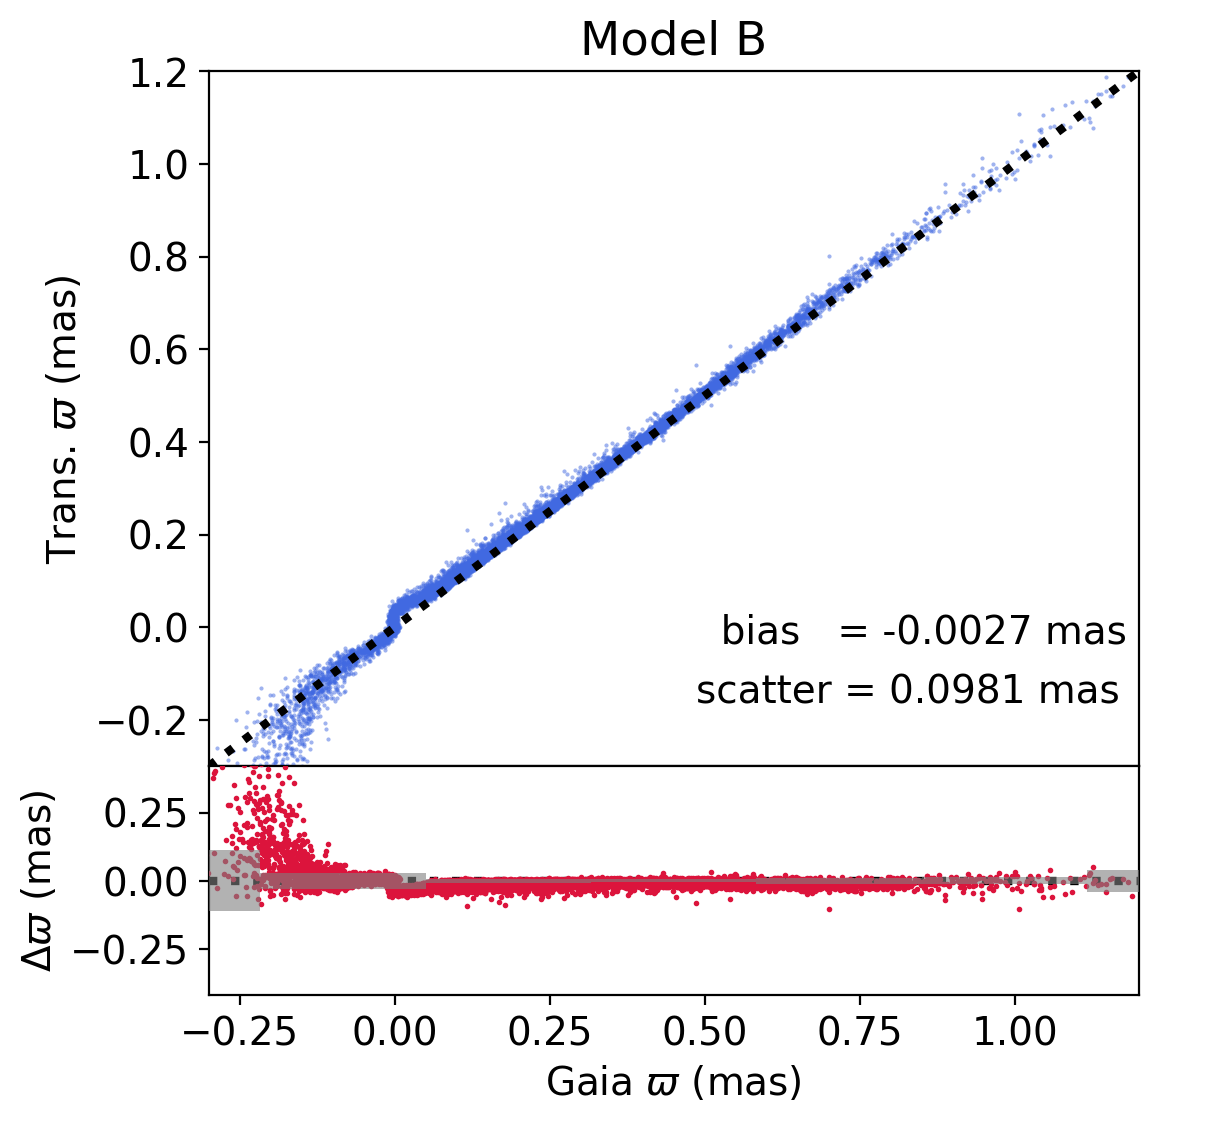

In [517]:

fig, ax = draw_compare(y_prt_B, out_prt_B, errorbar=False)
ax.set_title("Model B");

In [527]:
parent_df = pd.DataFrame({
    # 'trans_prlxA':out_prt_A[:,0],
    # 'trans_prlxB':out_prt[:,0],
    # 'e_trans_prlxA':out_prt_A[:,1],
    # 'e_trans_prlxB':out_prt[:,1],
    'trans_prlx':out_prt_B[:,0],
    'e_trans_prlx':out_prt_B[:,1],
    'tmass_id':id_prt_B
})

all_df = pd.concat([parent_df, outcome_df])


t_all = Table.from_pandas(all_df)
t_all.write(data_dir+'trans_all1101B.fits', overwrite=True)
t_all.write('trans_all1101B.fits', overwrite=True)

In [453]:
from astropy.table import Table, join


cat = Table.read(data_dir+"data_Hogg18_wise_gdr3.fits")

df = cat.to_pandas()

print(df.shape, df.columns)

(44783, 63) Index(['2MASS_ID', 'Gaia_parallax', 'Gaia_parallax_err', 'spec_parallax',
       'spec_parallax_err', 'training_set', 'sample', 'ASPCAP_ID', 'APOGEE_ID',
       'TELESCOPE', 'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K',
       'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'SNR', 'VHELIO_AVG', 'VSCATTER',
       'VERR', 'VERR_MED', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H',
       'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'AK_TARG', 'AK_TARG_METHOD',
       'AK_WISE', 'SFD_EBV', 'PMRA', 'PMDEC', 'Source', 'Gmag', 'e_Gmag',
       'o_BPmag', 'BPmag', 'e_BPmag', 'o_RPmag', 'RPmag', 'e_RPmag',
       'E(BP/RP)', 'BP-RP', 'BP-G', 'G-RP', 'Dist', 'b_Dist_x', 'B_Dist_xa',
       'AG', 'b_AG_x', 'B_AG_xa', 'E(BP-RP)', 'b_E(BP-RP)_x', 'B_E(BP-RP)_xa'],
      dtype='object')


In [454]:
# post_df = parent_df.merge(df, left_on='tmass_id', right_on='2MASS_ID')

cat_post = join(
    cat, t_all, join_type='inner',
    keys_left="2MASS_ID", keys_right="tmass_id",
)

len(cat_post)

37624

In [455]:
df_post = cat_post.to_pandas()
print(df_post.shape, df_post.columns)

(37624, 66) Index(['2MASS_ID', 'Gaia_parallax', 'Gaia_parallax_err', 'spec_parallax',
       'spec_parallax_err', 'training_set', 'sample', 'ASPCAP_ID', 'APOGEE_ID',
       'TELESCOPE', 'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K',
       'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'SNR', 'VHELIO_AVG', 'VSCATTER',
       'VERR', 'VERR_MED', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H',
       'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'AK_TARG', 'AK_TARG_METHOD',
       'AK_WISE', 'SFD_EBV', 'PMRA', 'PMDEC', 'Source', 'Gmag', 'e_Gmag',
       'o_BPmag', 'BPmag', 'e_BPmag', 'o_RPmag', 'RPmag', 'e_RPmag',
       'E(BP/RP)', 'BP-RP', 'BP-G', 'G-RP', 'Dist', 'b_Dist_x', 'B_Dist_xa',
       'AG', 'b_AG_x', 'B_AG_xa', 'E(BP-RP)', 'b_E(BP-RP)_x', 'B_E(BP-RP)_xa',
       'trans_prlx', 'e_trans_prlx', 'tmass_id'],
      dtype='object')


In [528]:
cat_par = join(
    cat, Table.from_pandas(parent_df), join_type='inner',
    keys_left="2MASS_ID", keys_right="tmass_id",
)

df_par = cat_par.to_pandas()
print(df_par.shape)

(16557, 66)


In [490]:
cat_tr = join(
    cat, Table.from_pandas(outcome_df), join_type='inner',
    keys_left="2MASS_ID", keys_right="tmass_id",
)

df_tr = cat_tr.to_pandas()
print(df_tr.shape)

(21067, 66)


# Uncertainty validation

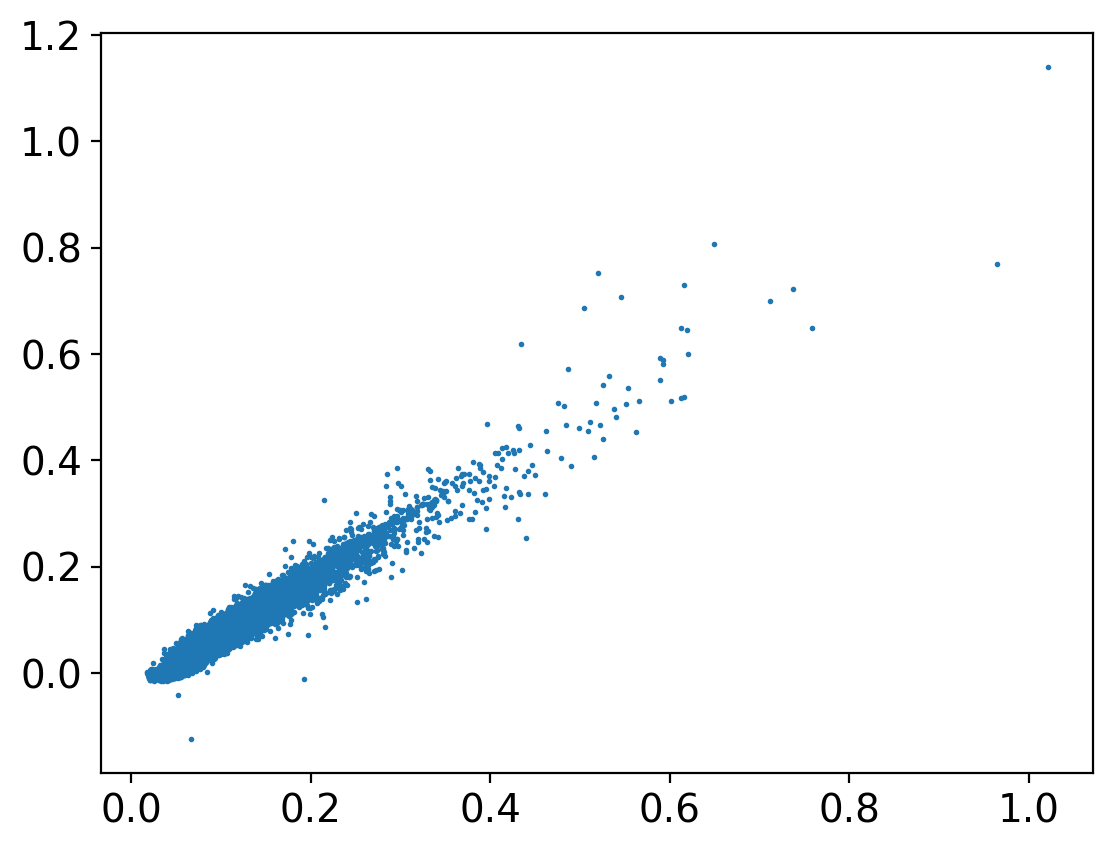

In [529]:
plt.scatter(cat_par['Gaia_parallax_err'], cat_par['e_trans_prlx'], s=1)

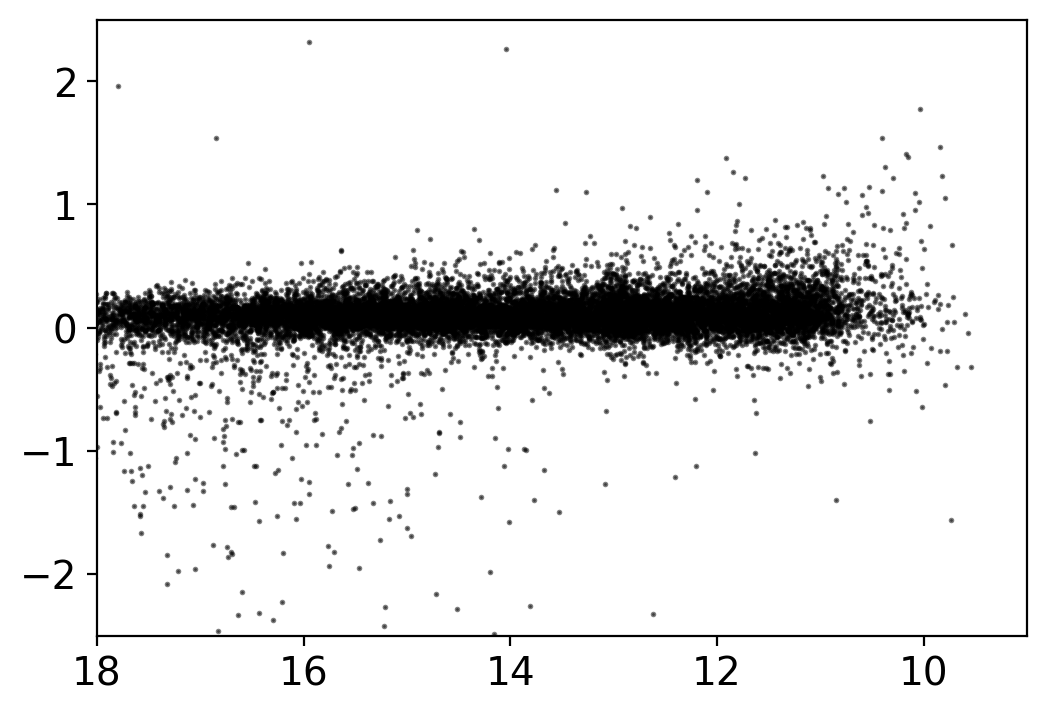

In [530]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.scatter(cat_par['Gmag'], 
           (cat_par['Gaia_parallax']-cat_par['trans_prlx'])/np.sqrt(cat_par['Gaia_parallax_err']**2),
           s=1, alpha=0.5, c='k')
ax.set_ylim([-2.5, 2.5]);
ax.set_xlim([18, 9]);

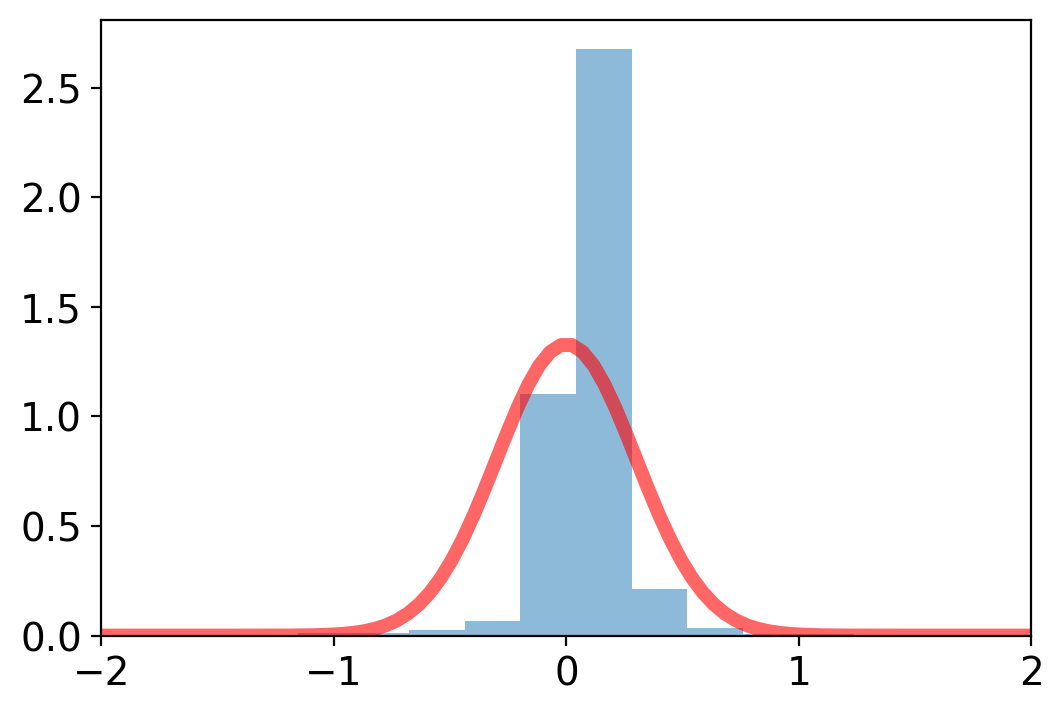

In [531]:
from scipy.stats import norm

xx = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
yy = norm.pdf(xx, 0, 0.3)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist((cat_par['Gaia_parallax']-cat_par['trans_prlx'])/np.sqrt(cat_par['Gaia_parallax_err']**2+cat_par['e_trans_prlx']**2),
        bins=50, alpha=0.5, density=True);
ax.plot(xx, yy, 'r-', lw=5, alpha=0.6)
ax.set_xlim([-2, 2]);

In [238]:
apsnr = np.array([0, 50, 100, 200, 500, 1000, 1500])
vscatter = np.array([0., 0.1, 0.5, 1.5])

df_post = df_post.assign(
    apsnr_bin=pd.cut(df_post['SNR'], bins=apsnr),
    vscatter_bin=pd.cut(df_post['VSCATTER'], bins=vscatter),
)

In [240]:
eprlx_snr = df_post.groupby(['apsnr_bin']).e_trans_prlx.median().values
eprlx_vscatter = df_post.groupby(['vscatter_bin']).e_trans_prlx.median().values


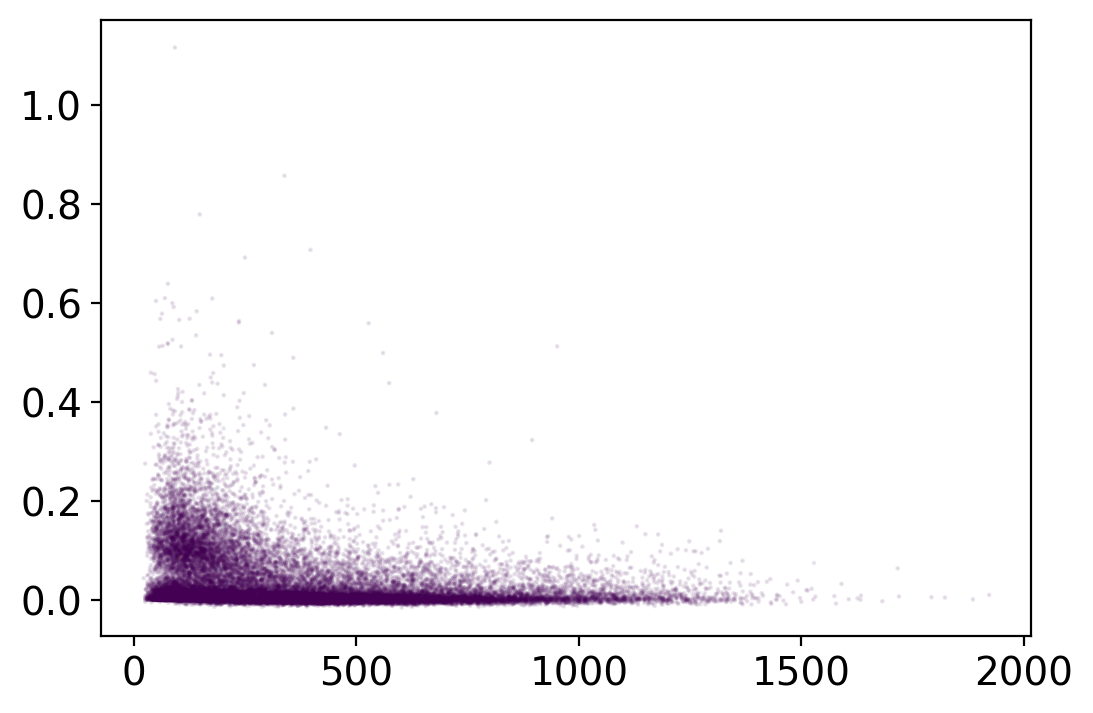

In [241]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.scatter(df_post['SNR'], df_post['e_trans_prlx'], 
           s=0.5, alpha=0.1, c=df_post['VSCATTER'])


In [248]:
m71_r = 0.1
m71_ind = (df_post['RA']>=298.444-m71_r) & (df_post['RA']<=298.444+m71_r) &\
            (df_post['DEC']>=18.779-m71_r) & (df_post['DEC']<=18.779+m71_r)
            # (df_post['PMRA']>=-3.416-1) & (df_post['PMRA']<=-3.416+1)
            # (df_post['PMDEC']>=-2.656-1) & (df_post['PMDEC']<=-2.656+1)
m71 = df_post[m71_ind]

m71.shape

(12, 68)

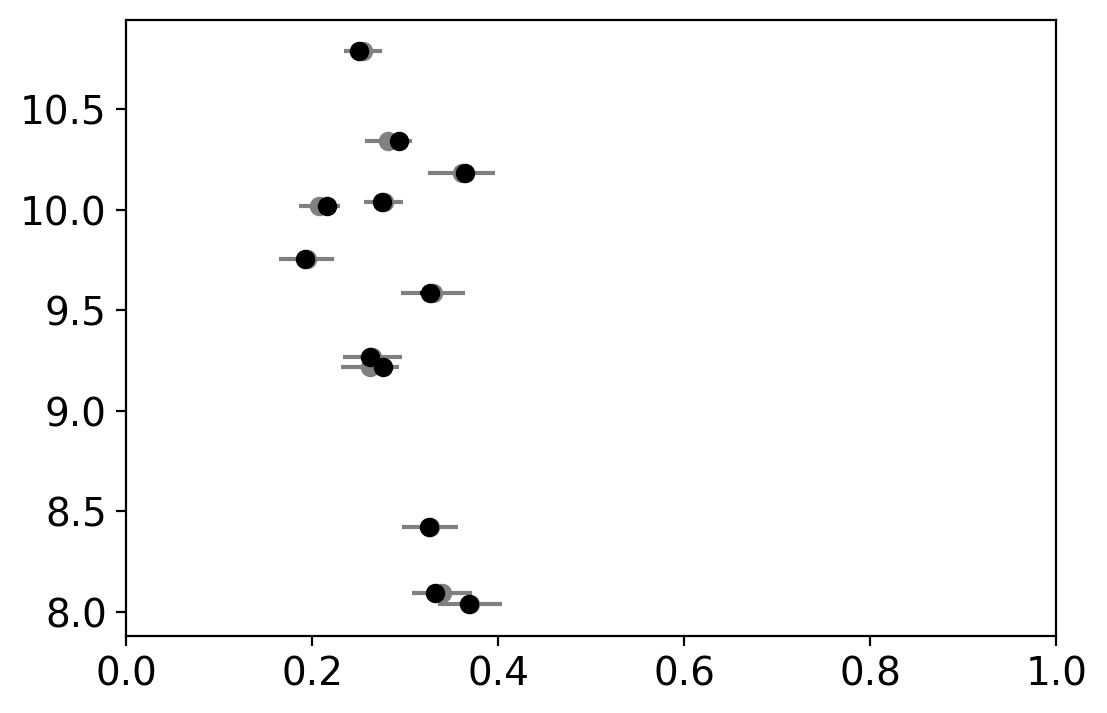

In [250]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.errorbar( m71['Gaia_parallax'], m71['K'],
            yerr=m71['K_ERR'], xerr=m71['Gaia_parallax_err'], c='grey', 
            fmt='o')

ax.errorbar( m71['trans_prlx'], m71['K'],
            yerr=m71['K_ERR'], xerr=m71['e_trans_prlx'], c='k', 
            fmt='o')

ax.set_xlim([0, 1]);

# Globular Cluster validation

In [372]:
from astropy.io import ascii
import seaborn as sns

# table = ascii.read("ftp://cdsarc.cds.unistra.fr/ftp/J/MNRAS/505/5978/tablea1.dat",
#                    readme="ftp://cdsarc.cds.unistra.fr/ftp/J/MNRAS/505/5978/ReadMe")
gctable =  ascii.read("ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/622/A191/table2.dat",
                   readme="ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/622/A191/ReadMe")

df_gcraw = gctable.to_pandas()

print(df_gcraw.shape, df_gcraw.columns)

(885, 48) Index(['---', '2MASS', 'Cluster', 'Evol', 'Teff', 'logg', '[Fe/H]', 'e_[Fe/H]',
       'l_[C/Fe]', '[C/Fe]', 'e_[C/Fe]', 'o_[C/Fe]', 'l_[N/Fe]', '[N/Fe]',
       'e_[N/Fe]', 'o_[N/Fe]', 'l_[O/Fe]', '[O/Fe]', 'e_[O/Fe]', 'o_[O/Fe]',
       'l_[Mg/Fe]', '[Mg/Fe]', 'e_[Mg/Fe]', 'o_[Mg/Fe]', 'l_[Al/Fe]',
       '[Al/Fe]', 'e_[Al/Fe]', 'o_[Al/Fe]', 'l_[Si/Fe]', '[Si/Fe]',
       'e_[Si/Fe]', 'o_[Si/Fe]', 'l_[K/Fe]', '[K/Fe]', 'e_[K/Fe]', 'o_[K/Fe]',
       'l_[Ca/Fe]', '[Ca/Fe]', 'e_[Ca/Fe]', 'o_[Ca/Fe]', 'l_[Ce/Fe]',
       '[Ce/Fe]', 'e_[Ce/Fe]', 'o_[Ce/Fe]', 'l_[Nd/Fe]', '[Nd/Fe]',
       'e_[Nd/Fe]', 'o_[Nd/Fe]'],
      dtype='object')


In [375]:

df_gcraw = df_gcraw.assign(tmass_id=df_gcraw['---']+df_gcraw['2MASS'])
df_gcraw.head()


,---,2MASS,Cluster,Evol,Teff,logg,[Fe/H],e_[Fe/H],l_[C/Fe],[C/Fe],...,o_[Ca/Fe],l_[Ce/Fe],[Ce/Fe],e_[Ce/Fe],o_[Ce/Fe],l_[Nd/Fe],[Nd/Fe],e_[Nd/Fe],o_[Nd/Fe],tmass_id
0,2M,17162228+4258036,M92,RGB,4978,1.84,NaN,NaN,NaN,NaN,...,1,<,1.928,NaN,1,NaN,NaN,NaN,0,2M17162228+4258036
1,2M,17163577+4256392,M92,RGB,5051,2.03,-2.199,0.254,<,1.684,...,1,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2M17163577+4256392
2,2M,17163748+4306155,M92,RGB,4389,0.42,-2.130,0.132,NaN,-0.364,...,1,NaN,-0.258,0.058,3,NaN,NaN,NaN,0,2M17163748+4306155
3,2M,17164330+4304161,M92,RGB,4949,1.76,-2.191,0.032,<,1.230,...,1,<,2.022,NaN,1,NaN,NaN,NaN,0,2M17164330+4304161
4,2M,17164395+4307318,M92,RGB,4913,1.67,-2.235,0.235,<,0.950,...,1,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2M17164395+4307318


In [456]:
df_post = df_post.assign(tmass_id=[i.decode('utf-8') for i in df_post['2MASS_ID'].values])
df_post.head()

,2MASS_ID,Gaia_parallax,Gaia_parallax_err,spec_parallax,spec_parallax_err,training_set,sample,ASPCAP_ID,APOGEE_ID,TELESCOPE,...,B_Dist_xa,AG,b_AG_x,B_AG_xa,E(BP-RP),b_E(BP-RP)_x,B_E(BP-RP)_xa,trans_prlx,e_trans_prlx,tmass_id
0,b'2M00000002+7417074',0.3191,0.0329,0.3185,0.0164,0,b'B',b'apogee.apo25m.s.l31c.2.5046.2M00000002+7417074',b'2M00000002+7417074',b'apo25m ',...,6871.655762,1.2574,1.2309,1.2965,0.7237,0.7098,0.7447,0.314420,-0.001212,2M00000002+7417074
1,b'2M00000317+5821383',0.3643,0.0510,0.4428,0.0183,0,b'A',b'apogee.apo25m.s.l31c.2.4424.2M00000317+5821383',b'2M00000317+5821383',b'apo25m ',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.350877,0.018951,2M00000317+5821383
2,b'2M00000546+6152107',0.3154,0.0351,0.3292,0.0164,0,b'B',b'apogee.apo25m.s.l31c.2.5045.2M00000546+6152107',b'2M00000546+6152107',b'apo25m ',...,2175.337158,2.0415,2.0233,2.0482,1.0828,1.0723,1.0865,0.308101,0.000184,2M00000546+6152107
3,b'2M00001719+6221324',0.1395,0.0439,0.1564,0.0128,0,b'B',b'apogee.apo25m.s.l31c.2.5045.2M00001719+6221324',b'2M00001719+6221324',b'apo25m ',...,6506.370117,4.1775,4.1487,4.2002,2.3713,2.3568,2.3839,0.140876,0.007649,2M00001719+6221324
4,b'2M00002005+5703467',0.3003,0.0247,0.2372,0.0203,0,b'B',b'apogee.apo25m.s.l31c.2.4264.2M00002005+5703467',b'2M00002005+5703467',b'apo25m ',...,4639.095703,1.5314,1.5227,1.5422,0.8116,0.8066,0.8177,0.296224,-0.004326,2M00002005+5703467


In [457]:
df_gc = pd.merge(df_post, df_gcraw, on="tmass_id", )

In [385]:
df_gc.Cluster.unique()

array(['M53', 'M3', 'N5466', 'M5', 'M107', 'M13', 'M92', 'M71', 'M15',
       'M2'], dtype=object)

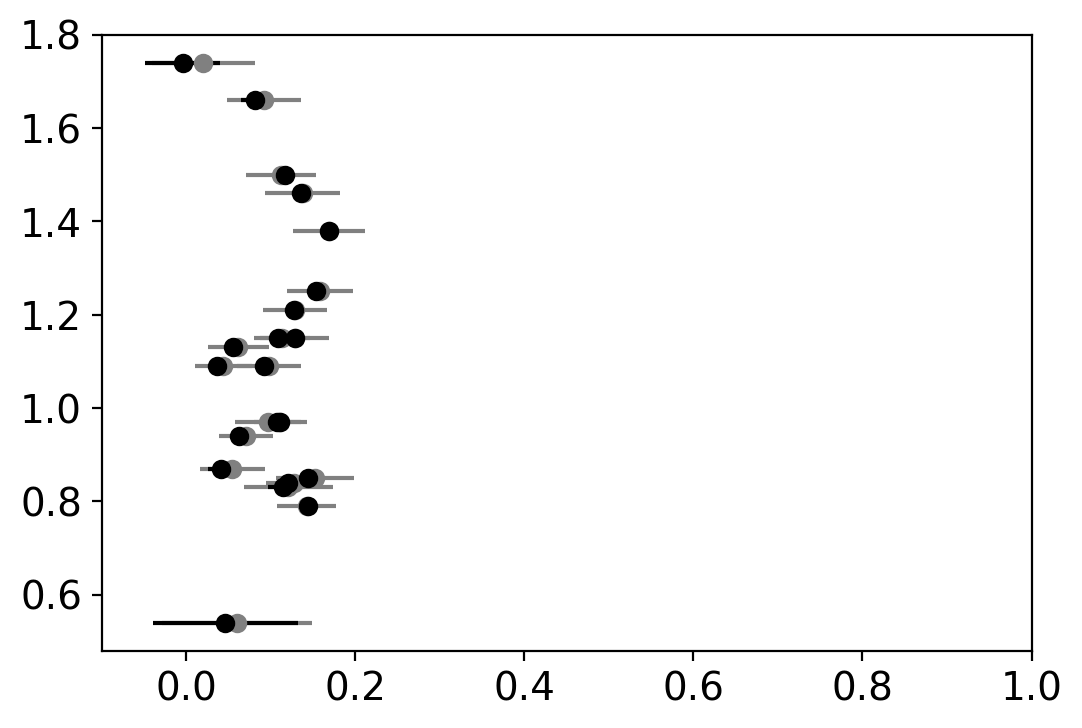

In [398]:
ind = df_gc['Cluster']==df_gc.Cluster.unique()[9]


fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.errorbar(df_gc[ind]['Gaia_parallax'], df_gc[ind]['logg'],
            xerr=df_gc[ind]['Gaia_parallax_err'], c='grey', 
            fmt='o')

ax.errorbar(df_gc[ind]['trans_prlx'], df_gc[ind]['logg'],
            xerr=df_gc[ind]['e_trans_prlx'], c='k', 
            fmt='o')

ax.set_xlim([-0.1, 1]);

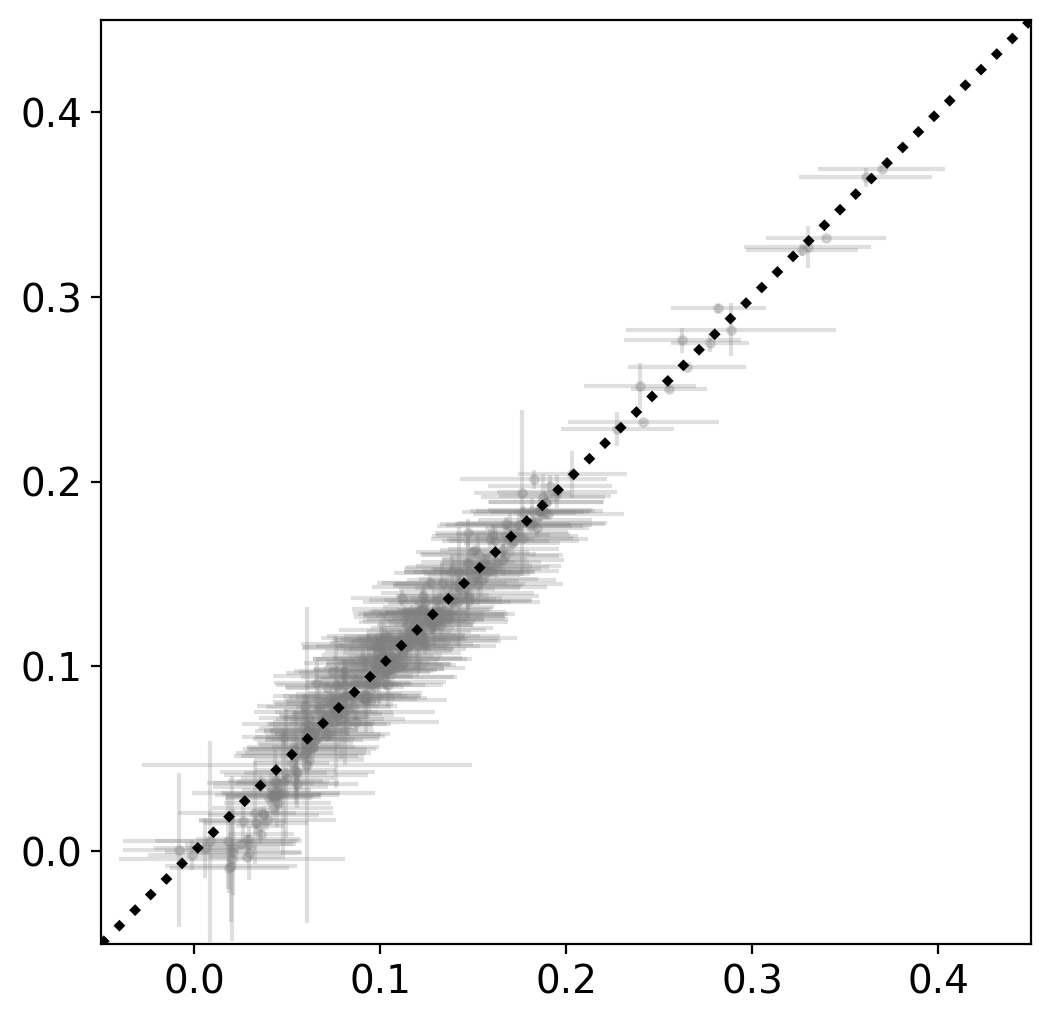

In [401]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

xx = np.linspace(-0.5, 1.5)
ax.plot(xx, xx, ls=':', lw=3, c='k', zorder=5)
ax.errorbar(df_gc['Gaia_parallax'], df_gc['trans_prlx'],
            xerr=df_gc['Gaia_parallax_err'],
            yerr=df_gc['e_trans_prlx'],  c='grey', 
            alpha=0.25, fmt='.')

ax.set_xlim([-0.05, 0.45]);
ax.set_ylim([-0.05, 0.45]);

In [532]:
df_gc

,2MASS_ID,Gaia_parallax,Gaia_parallax_err,spec_parallax,spec_parallax_err,training_set,sample,ASPCAP_ID,APOGEE_ID,TELESCOPE,...,e_[Ca/Fe],o_[Ca/Fe],l_[Ce/Fe],[Ce/Fe],e_[Ce/Fe],o_[Ce/Fe],l_[Nd/Fe],[Nd/Fe],e_[Nd/Fe],o_[Nd/Fe]
0,b'2M13121714+1814178',0.0392,0.0367,0.0782,0.0080,1,b'A',b'apogee.apo25m.s.l31c.2.4128.2M13121714+1814178',b'2M13121714+1814178',b'apo25m ',...,NaN,1,<,0.561,NaN,1,<,1.213,NaN,1
1,b'2M13122857+1815051',0.0399,0.0234,0.0875,0.0039,1,b'B',b'apogee.apo25m.c.l31c.2.4128.2M13122857+1815051',b'2M13122857+1815051',b'apo25m ',...,0.027,1,NaN,-0.205,0.084,3,NaN,NaN,NaN,0
2,b'2M13123506+1814286',0.0372,0.0298,0.0772,0.0077,1,b'B',b'apogee.apo25m.s.l31c.2.4128.2M13123506+1814286',b'2M13123506+1814286',b'apo25m ',...,NaN,1,<,1.054,NaN,1,NaN,NaN,NaN,0
3,b'2M13123617+1807320',0.0595,0.0257,0.0617,0.0045,1,b'B',b'apogee.apo25m.s.l31c.2.4128.2M13123617+1807320',b'2M13123617+1807320',b'apo25m ',...,NaN,1,<,0.407,NaN,1,NaN,NaN,NaN,0
4,b'2M13123617+1827323',0.0803,0.0380,0.0699,0.0083,1,b'A',b'apogee.apo25m.s.l31c.2.4128.2M13123617+1827323',b'2M13123617+1827323',b'apo25m ',...,NaN,1,<,0.740,NaN,1,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,b'2M21333432-0051285',0.0707,0.0320,0.1194,0.0089,0,b'B',b'apogee.apo25m.c.l31c.2.4260.2M21333432-0051285',b'2M21333432-0051285',b'apo25m ',...,0.016,2,NaN,0.075,0.101,3,NaN,NaN,NaN,0
334,b'2M21333520-0046089',0.1426,0.0350,0.1210,0.0059,1,b'A',b'apogee.apo25m.s.l31c.2.4260.2M21333520-0046089',b'2M21333520-0046089',b'apo25m ',...,0.046,2,NaN,0.149,0.057,4,NaN,NaN,NaN,0
335,b'2M21333827-0054569',0.0607,0.0887,0.1234,0.0091,0,b'A',b'apogee.apo25m.s.l31c.2.2011.2M21333827-0054569',b'2M21333827-0054569',b'apo25m ',...,0.033,3,NaN,0.147,0.033,5,NaN,NaN,NaN,0
336,b'2M21333847-0050263',0.1377,0.0439,0.1046,0.0099,0,b'B',b'apogee.apo25m.s.l31c.2.2011.2M21333847-0050263',b'2M21333847-0050263',b'apo25m ',...,0.183,1,<,0.649,NaN,1,NaN,NaN,NaN,0


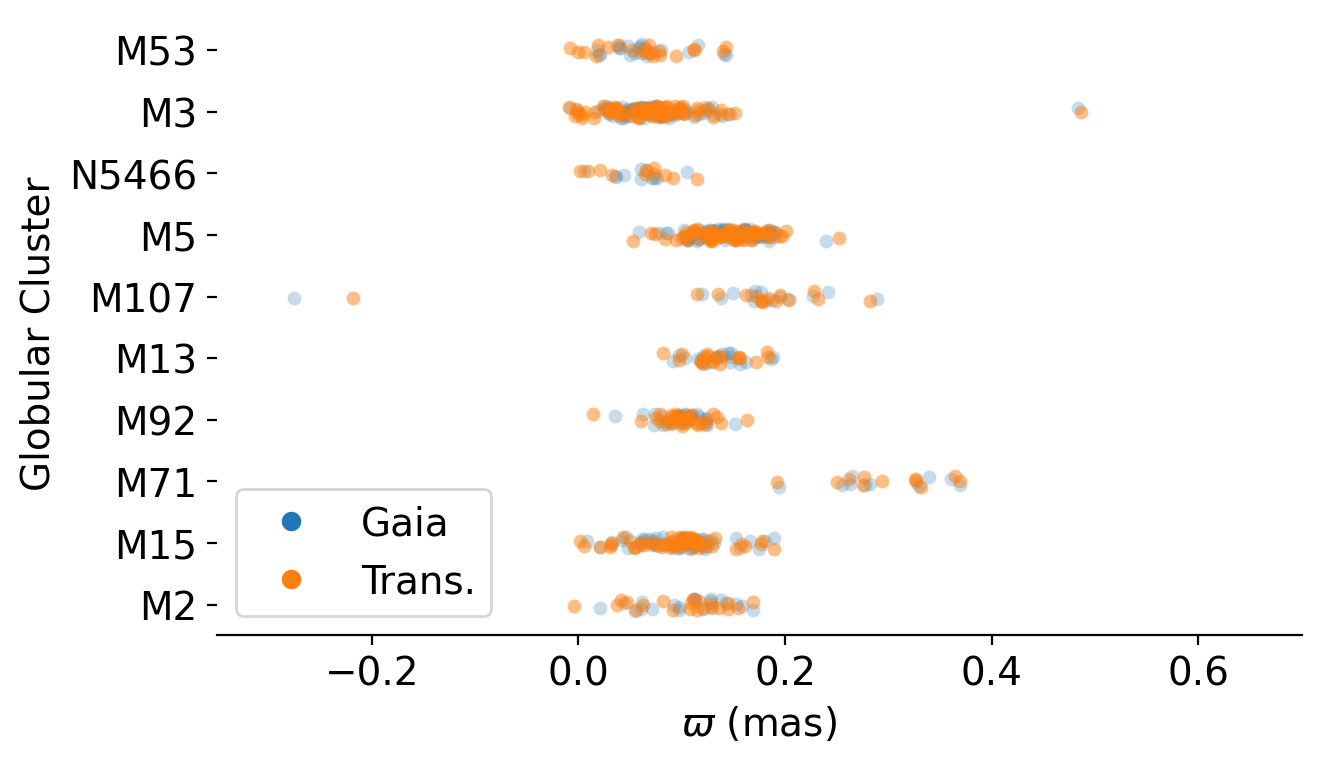

In [458]:
# Initialize the figure


from matplotlib.lines import Line2D

f, ax = plt.subplots(1,1,figsize=(7,4))
sns.despine(left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=df_gc, x="Gaia_parallax", y="Cluster", 
    # hue="species",
    dodge=True, alpha=.25, zorder=1, legend=False
)

sns.stripplot(
    data=df_gc, x="trans_prlx", y="Cluster", 
    dodge=True, alpha=.5, zorder=1, legend=False
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Gaia', markerfacecolor='#1f77b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Trans.', markerfacecolor='#ff7f0e', markersize=8)
]

ax.legend(handles=legend_elements, loc='lower left')
ax.set_xlim([-0.35, 0.7]);
ax.set_xlabel(r"$\varpi$ (mas)");
ax.set_ylabel("Globular Cluster ");

In [364]:
# def select_gc(df, ra, dec, pmra, pmdec, Nrscale):
    
#     ind = (df['RA']>=ra-Nrscale) & (df['RA']<=ra+Nrscale) &\
#             (df['DEC']>=dec-Nrscale) & (df['DEC']<=dec+Nrscale) &\
#             (df['PMRA']>pmra-0.5) & (df['PMRA']<=pmra+0.5) &\
#             (df['PMDEC']>pmdec-0.5) & (df['PMDEC']<=pmdec+0.5)
#     return ind

# N_gc_thresold = 5
# df_gc = pd.DataFrame()
# inds = []
# prlxs_gc = []
# scatter_prlxs = []

# for i in range(len(table)):
#     ind = select_gc(df_post, df_gcraw['RAdeg'][i], df_gcraw['DEdeg'][i],
#                     df_gcraw['pmRA'][i], df_gcraw['pmDE'][i], 
#                     3.*df_gcraw['Rscale'][i]/60.)
    
#     if len(df_post[ind])>N_gc_thresold:
#         df_gc = pd.concat([df_gc, df_gcraw.iloc[i]], axis=1)
#         inds.append(ind)
        
# df_gc = df_gc.T

In [365]:
# prlx_trans = [df_post[ind].trans_prlx.median() for ind in inds if len(df_post[ind])>=N_gc_thresold]
# eprlx_trans = [df_post[ind].trans_prlx.std()   for ind in inds if len(df_post[ind])>=N_gc_thresold]

# prlx_gaia = [df_post[ind].Gaia_parallax.median() for ind in inds if len(df_post[ind])>=N_gc_thresold]
# eprlx_gaia = [df_post[ind].Gaia_parallax.std()   for ind in inds if len(df_post[ind])>=N_gc_thresold]

# prlx_hogg = [df_post[ind].spec_parallax.median()  for ind in inds if len(df_post[ind])>=N_gc_thresold]
# eprlx_hogg = [df_post[ind].spec_parallax.std()    for ind in inds if len(df_post[ind])>=N_gc_thresold]